In [1]:
import base

import numpy as np
import math
import torch
import matplotlib.pyplot as plt
import datetime
import pandas_datareader as pdr

import torchcde
# import torchsde
# import signatory

from sigMMD import SigMMD, SigMMD_naive, hypothesis_test

In [2]:
# ^GSPC is S&P 500.
ticker = "^GSPC"

start = datetime.date(2000, 1, 1)
end = datetime.date(2019, 1, 1)
freq = 'M'

data = pdr.get_data_yahoo(ticker, start, end)["Close"]

In [20]:
length = 15

In [21]:
returns = []
for _, dat in data.resample(freq):
    path = dat.values / dat.values[0]
    if len(path)>= length:
        path = path[:length]
        path = np.c_[np.linspace(0.,1.,length), path]
        returns.append(path)

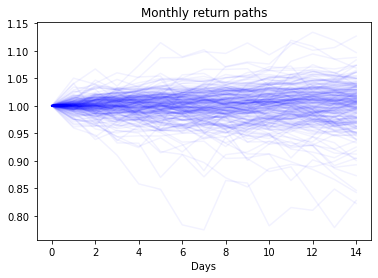

In [22]:
for ret_path in returns:
    plt.plot(ret_path[:,1], "b", alpha=0.05)

plt.title("Monthly return paths")
plt.xlabel("Days")
plt.show()

In [23]:
# # data to generate
# y_data = torch.stack([torch.tensor(r) for r in returns]).float()

# num_samples = y_data.shape[0]

# # time grid
# times = torch.linspace(0., 1., length)

# # Brownian motion simulator
# bm = torchsde.BrownianInterval(t0=0., t1=1., size=(num_samples, 1))

# # generate sample increments from Brownian motion 
# bm_increments = torch.stack([bm(t0, t1) for t0, t1 in zip(times[:-1], times[1:])], dim=0)

# # generate sample paths from Brownian motion
# bm_paths = torch.cat((torch.zeros(1, num_samples, 1), torch.cumsum(bm_increments, dim=0)))
# bm_paths = bm_paths.permute(1,0,2)

# # include time as a channel
# times_ =  times.unsqueeze(0).unsqueeze(-1).expand(num_samples, length, 1)
# x_data = torch.cat([times_, bm_paths], dim=2)  

In [24]:
# torch.save(x_data, '../data/S&P_500_x_data.pt')
# torch.save(y_data, '../data/S&P_500_y_data.pt')

In [25]:
x_data = torch.load('../data/S&P_500_x_data.pt')
y_data = torch.load('../data/S&P_500_y_data.pt')

In [26]:
x_data.shape

torch.Size([228, 15, 2])

In [27]:
y_data.shape

torch.Size([228, 15, 2])

In [28]:
class VectorField(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, inner_dim=32):
        ######################
        # input_dim is the number of input channels in the data X. (Determined by the data.)
        # hidden_dim is the number of channels for z_t. (Determined by you.)
        ######################
        super(VectorField, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.linear1 = torch.nn.Linear(hidden_dim, inner_dim)
        self.linear2 = torch.nn.Linear(inner_dim, inner_dim)
        self.linear3 = torch.nn.Linear(inner_dim, input_dim * hidden_dim)

    ######################
    # The t argument is not used here; it can be used when you want your CDE to behave differently at different times.
    ######################
    def forward(self, t, z):

        # z has shape (batch, hidden_channels)
        z = self.linear1(z)
        z = z.relu()
        # z = self.linear2(z)
        # z = z.relu()
        z = self.linear3(z)
        z = z.tanh()
        ######################
        # Ignoring the batch dimension, the shape of the output tensor must be a matrix,
        # because we need it to represent a linear map from R^input_channels to R^hidden_channels.
        ######################
        z = z.view(z.size(0), self.hidden_dim, self.input_dim)
        return z

In [29]:
class NeuralCDE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        
        super(NeuralCDE, self).__init__()

        self.func = VectorField(input_dim, hidden_dim)

        self.initial = torch.nn.Linear(input_dim, hidden_dim)
        self.readout = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):

        # x, t = torchcde.logsignature_windows(x, depth=2, window_length=5)

        coeffs = torchcde.linear_interpolation_coeffs(x)
        # coeffs = linear_interpolation_coeffs(X_input, rectilinear=0)
        X = torchcde.LinearInterpolation(coeffs)

        # coeffs = torchcde.natural_cubic_coeffs(x)
        # X = torchcde.NaturalCubicSpline(coeffs)
        
        X0 = X.evaluate(X.interval[0])
        z0 = self.initial(X0)

        z = torchcde.cdeint(X=X, 
                            func=self.func, 
                            z0=z0, 
                            t=X.grid_points,
                            method='dopri5', 
                            options=dict(grid_points=X.grid_points, eps=1e-5)
                            )

        y = self.readout(z)
        return y

In [30]:
def suggest_initial_lengthscales(X, num_samples=None):

    X = X.reshape([-1, X.shape[-1]])

    if num_samples is not None and num_samples < X.shape[0]:

        X = X[np.random.choice(X.shape[0], size=(num_samples), replace=False)]

    l_init = torch.sqrt(torch.mean(torch.reshape(X[:, None, :]**2 + X[None, :, :]**2 - 2 * X[:, None, :] * X[None, :, :], (-1, X.shape[1])), axis=0) * X.shape[1])

    return np.maximum(l_init, 1.)

In [66]:
model = NeuralCDE(input_dim=2, hidden_dim=16, output_dim=2)
# model = NeuralCDE(input_dim=signatory.logsignature_channels(3,2), hidden_dim=8, output_dim=2)

In [94]:
x_train = x_data[50:].cuda()
y_train = y_data[50:].cuda()
x_test = x_data[:50].cuda()
y_test = y_data[:50].cuda()

model = model.cuda()

In [95]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [96]:
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32)

In [97]:
sigma = max(suggest_initial_lengthscales(x_train.cpu())**2).cuda().item()

In [98]:
criterion = SigMMD_naive(n=0, solver=1, rbf=True, sigma=5)
# criterion = SigMMD(n=2, solver=2)
# criterion = torch.nn.MSELoss()

In [99]:
losses = []

In [101]:
num_epochs = 100

for epoch in range(num_epochs):

    for batch in train_dataloader:
        x, y = batch
        pred_y = model(x)
        loss = criterion(pred_y, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    losses.append(loss.item())
    
    if epoch%10==0:
        model.eval()
        with torch.no_grad():
            y_pred = model(x_test)
            test_loss = criterion(y_pred, y_test)
        print('Epoch: {}   Training loss: {}   Test loss: {}'.format(epoch, loss.item(), test_loss.item()))
        model.train()

Epoch: 0   Training loss: 0.2466193586587906   Test loss: 0.14807239174842834
Epoch: 10   Training loss: 0.008056964725255966   Test loss: 0.003728296374902129
Epoch: 20   Training loss: 0.000607264053542167   Test loss: 0.0026992016937583685
Epoch: 30   Training loss: 0.00237733731046319   Test loss: 0.04820183664560318
Epoch: 40   Training loss: 0.013543699868023396   Test loss: 0.013812706805765629
Epoch: 50   Training loss: 0.003235518466681242   Test loss: 0.00439964747056365


KeyboardInterrupt: 

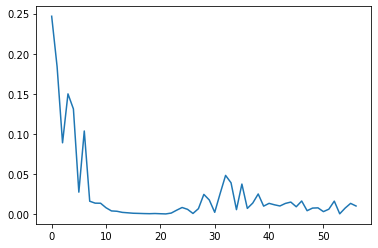

In [102]:
plt.plot(losses)
plt.show()

In [103]:
y_pred = model(x_test)

In [104]:
y_pred_ = y_pred.cpu().detach().numpy()
y_test_ = y_test.cpu().detach().numpy()

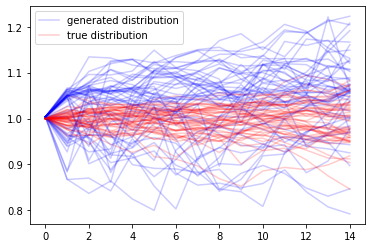

In [105]:
for k in range(50):
    plt.plot(y_pred_[k][:,1], 'b', alpha=0.2, label='generated distribution' if k==0 else '')
    plt.plot(y_test_[k][:,1], 'r', alpha=0.2, label='true distribution' if k==0 else '')
plt.legend()
plt.show()

In [106]:
y_pred_ = y_pred.cpu().detach().double()
y_test_ = y_test.cpu().detach().double()

In [109]:
hypothesis_test(y_pred_, y_test_, n=6, solver=1)

KeyboardInterrupt: 